# Modules, functions

In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 1000)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

Loading BokehJS ...

In [2]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

# ----------------------------------------------------------------

def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

# ----------------------------------------------------------------

def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

# Data

In [8]:

us_FW20 = pd.read_csv('data/rma1_us.csv', low_memory = False, error_bad_lines = False, sep = ";")
us = pd.read_csv('data/us_seasons.csv') #, low_memory = False, error_bad_lines = False, sep = ",")


# --- FW20 ---
us_FW20 = us_FW20[us_FW20.Season == 'FW2020']
us_FW20.head()
print('Total FW20:', len(us_FW20.Article.unique()))


# --- FW19 ---
us_FW19 = us[us.season == 'FW19']
us_FW19.head()
print('Total FW19:', len(us_FW19.article_number.unique()))

us_carryovers = set(us_FW20.Article).intersection(set(us_FW19.article_number))

print()
print('Carryovers:', len(us_carryovers))

,Season,Article,TBD,Sub_Brand,Division,Key_Category,Business_Segment
0,FW2020,011040,NaN,BADGE OF SPORTS,Footwear,FOOTBALL ADIDAS,FOOTBALL FTW ADIDAS
1,FW2020,015110,NaN,BADGE OF SPORTS,Footwear,FOOTBALL ADIDAS,FOOTBALL FTW ADIDAS
2,FW2020,019000,NaN,BADGE OF SPORTS,Footwear,FOOTBALL ADIDAS,FOOTBALL FTW ADIDAS
3,FW2020,019228,NaN,BADGE OF SPORTS,Footwear,FOOTBALL ADIDAS,FOOTBALL FTW ADIDAS
4,FW2020,019310,NaN,BADGE OF SPORTS,Footwear,FOOTBALL ADIDAS,FOOTBALL FTW ADIDAS


Total FW20: 20049


,article_number,brand,season
180,CV3196,ADIDAS,FW19
181,DB3065,ADIDAS,FW19
182,CY9852,ADIDAS,FW19
183,DV1726,ADIDAS,FW19
184,CG6211,ADIDAS,FW19


Total FW19: 21894

Carryovers: 974


In [ ]:
FW20_w_ref = pd.merge(
    us_FW20,
    ref_dat0[['article_no', 'art_desc']],
    how = 'left', left_on = 'Article', right_on = 'article_no'
)
    

In [3]:
us_dat0 = pd.read_csv('data/ch4k_df_us.csv', low_memory = False)

ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc',
                                 'brand_desc'])



In [ ]:
us_dat0.columns

In [4]:
us_dat0['clearance'] = us_dat0.clearance.fillna(0)

# Remove clearance transactions!!
us_dat0['net_qty'] = (1 - us_dat0.clearance)*us_dat0.net_qty

In [5]:
dat = us_dat0.copy()
ref_dat = ref_dat0.copy()

In [ ]:
# na_test = us_dat0[(us_dat0.season == 'FW19') & (us_dat0.article_number.isin(us_carryovers))].sort_values(['article_number', 'year', 'week'])
# na_test.shape

# na_test2 = na_test[na_test.buy_availability.isna()]
# # pd.crosstab(index = na_test2.week, columns = 'count')
# na_test2.shape

# GAS

In [9]:
dat_GAS = us_dat0.copy()[['article_number', 'year', 'week', 'season', 'net_qty', 'buy_availability']]

dat_GAS = dat_GAS[(dat_GAS.season == 'FW19') & (dat_GAS.article_number.isin(us_carryovers))].sort_values(['article_number', 'year', 'week'])

dat_GAS['buy_availability'] = pd.DataFrame(dat_GAS.groupby('article_number')['buy_availability'].fillna(method = 'ffill'))

# len(dat_GAS.article_number.unique())
# dat_GAS[:15]

# dat_GAS.shape

In [10]:
# dat_GAS_a = np.random.choice(dat_GAS.article_number.unique(), size = 100, replace = False)
# dat_GAS = dat_GAS[dat_GAS.article_number.isin(dat_GAS_a)]

dat_GAS = dat_GAS.groupby(['article_number']).apply(GAS_est).reset_index()
dat_GAS = pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: overflow encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


# Seasonality

In [ ]:
%whos 

In [11]:
seasonality_dat = (us_dat0.copy()
                   [['article_number', 'year', 'week', 'season', 'net_qty', 
                     'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
                     'age_group_desc', 'franchise', 'prod_grp_desc']].
                   dropna().sort_values(['article_number', 'year', 'week'])
                  )


# -- Reliable, mirror seasons --
seasonality_dat = seasonality_dat[~seasonality_dat.season.isin(['FW14', 'FW15', 'SS14','SS15', 'SS16', 'SS17', 'SS18', 'SS19'])]



In [12]:
# ---- Calculate cat-level weekly means across *ALL SEASONS* ---- 

seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]



In [13]:
def regress(df):
    # function for regressing article net_qty on seasonalities
    # for article a's level of each category, retreive weekly means, then regress 
    
    df = df.sort_values(['article_number', 'year', 'week'])
        
    # article net_demand_qty
    y = df[['net_qty', 'week']].set_index('week')

    # article category-level weekly means; set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
          merge(x_rmh, left_index=True, right_index=True, how = 'outer').
          merge(x_gndr, left_index=True, right_index=True, how = 'outer').
          merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
          merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
          merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities

    y = yX.net_qty
    
    X = yX.drop('net_qty', axis = 1)
    # X = sm.add_constant(X) # ****** ******* *******
    
    mod = sm.OLS(y, X, missing='drop').fit()
    # print(df.article_number.unique(), round(mod.rsquared, 2))

    ret = pd.DataFrame(index = X.index)
    ret['seas_preds'] = mod.predict(X).round()
    
    ret = ret.reset_index()
    ret = pd.DataFrame(ret.groupby('week')['seas_preds'].mean())

    return ret

In [14]:
# Subset to carryover for regression
seasonality_dat = seasonality_dat[(seasonality_dat.article_number.isin(us_carryovers))].sort_values(['article_number', 'year', 'week']) 

len(seasonality_dat.article_number.unique()) # 974

# ----- Subset for development -----
# a = np.random.choice(seasonality_dat.article_number.unique(), size = 3, replace = False)
# seasonality_dat = seasonality_dat[seasonality_dat.article_number.isin(dat_GAS_a)].copy()



974

In [15]:
# regress articles of interest on seasonality

preds = seasonality_dat.groupby(['article_number']).apply(regress).reset_index()


In [16]:
# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks

preds = pd.merge(
    preds,
    seasonality_dat[seasonality_dat.season == 'FW19'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')

# Zero out negative fitted values
preds['seas_preds'] = np.where(preds.seas_preds > 0, preds.seas_preds, 0) 

# Combine
preds = pd.merge(
    preds,   # all weeks
    dat_GAS, # observed weeks
    how = 'left')


# EDA Plots

In [ ]:
preds_season = preds_season.reset_index()

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
a = 'CV3998'
aoi = a

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
      
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week')

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season[preds_season.index == a]

dat_aoi = us_dat0[us_dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# Aggregate to Season

In [17]:
# weekly assignment of GAS, seasonality, or combination
preds['y_hat'] = np.where(np.isnan(preds.GAS_est), preds.seas_preds, (preds.GAS_est + preds.seas_preds)/2)

# Sum over season
preds_season = pd.DataFrame(preds.groupby('article_number')['y_hat'].apply(sum).round())

# Add 10 percent growth (???)
preds_season['y_hat'] = preds_season['y_hat']*1.1 


# Overbuy

In [18]:
from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(mu, sigma, margin, cost, b):
    I = lambda x: L(x, b, margin, cost) * stats.norm.pdf(x, mu, sigma) # I for integrand
    Exp_loss = integrate.quad(I, 0, mu + 3*sigma)/(1 - stats.norm.cdf(0, loc = mu, scale = sigma)) # Expected value of Loss function
    return round(Exp_loss[0], 2) 

def minimize_EL(mu, sigma, margin, cost):
    if(mu < 1000):
        return 1.2*mu 
    if(np.isnan(margin)):
        return 1.2*mu
    p = partial(EL, mu, sigma, margin, cost) # Make EL function of only one var: b_0
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*sigma))
    return int(buy_opt['x']) # optimal buy quantity

In [19]:
dat0 = pd.read_csv('data/ch4k_df.csv')


In [20]:
# Load cost/margin data
cost_margin = dat0.copy()
cost_margin = pd.DataFrame(
    cost_margin[cost_margin.season.isin(['SS18', 'FW18', 'SS19', 'FW19'])].
                groupby('article_number')[['margin', 'cost']].
                mean()
).round()

In [21]:
# Add cost and margin for optimal overbuy estimation                                                                           
preds_season = pd.merge(preds_season, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()

In [22]:
# see evaluation.ipynb for sd estimation 

opt_ovb_all = pd.DataFrame(preds_season.
                           apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_all = opt_ovb_all.rename(columns = {opt_ovb_all.columns[0]: 'Opt_Ovb'})

In [23]:
preds_season = pd.merge(
    preds_season, # everything
    opt_ovb_all,  # optimal overbuy
    right_index= True, left_index= True
)

# Additional Columns 

In [24]:
preds_season = pd.merge(
    preds_season,
    ref_dat0[['article_no', 'model_no', 'art_desc', 'prod_type_desc', 'brand_desc']],
    how = 'left', left_on = 'article_number', right_on='article_no'
)


In [25]:
preds_season = preds_season.rename(columns = {'y_hat': 'DAA_forecast',
                                              'Opt_Ovb': 'buy_recommendation',
                                              'art_desc': 'description', 
                                              'prod_type_desc': 'type',
                                              'brand_desc': 'brand'})

In [26]:
preds_season = preds_season.set_index('article_no')

In [27]:
# Convert to integers to remove '.0' endings
for c in preds_season.columns:
    if type(preds_season[c][1]) == np.float64:
        preds_season[c] = preds_season[c].fillna(0).astype(int)

In [28]:

preds_season = preds_season[['DAA_forecast', 'buy_recommendation',
                             'brand', 'model_no', 'description', 'type']]

# preds_season['DAA_forecast'] = preds_season['DAA_forecast'].astype('int')
# preds_season['buy_recommendation'] = preds_season['buy_recommendation'].astype('int')

# preds_season = preds_season.sort_values('DAA_forecast', ascending = False)

In [ ]:

# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
a = 'S82137'
aoi = a

FW20_w_ref[FW20_w_ref['Article'] == a]


dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
      
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week')

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

# preds_season[preds_season.article_number == a]

dat_aoi = us_dat0[us_dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi[dat_aoi.date > dat_aoi.date[55]][['date', 'net_qty']]



In [29]:
preds_season = preds_season.sort_values(by = 'article_no', axis = 'index')

In [40]:
preds.head()
preds_season.head()
sanity_check = pd.merge(
    preds_season,
    pd.DataFrame(preds.groupby('article_number')['net_qty'].sum()),
    right_on='article_number', left_index=True
)[['net_qty', 'DAA_forecast']]

sanity_check['diff'] = abs(sanity_check.net_qty - sanity_check.DAA_forecast)

In [49]:
sanity_check.shape # (974, 3)
sanity_check[sanity_check.net_qty > 100].sort_values('diff', ascending=False).round() # (435, 3)

(974, 3)

,net_qty,DAA_forecast,diff
article_number,,,
B41720,2577.0,19055,16478.0
BA8775,2791.0,19159,16368.0
M20605,529.0,15050,14521.0
DZ6168,1227.0,8472,7245.0
M20324,4375.0,11260,6885.0
D95958,3588.0,9208,5620.0
AJ5880,677.0,6159,5482.0
DZ8765,3473.0,8309,4836.0
D95957,2018.0,6024,4006.0


In [56]:
# ---- Comments ----

# preds_season = preds_season.set_index('article_number')

preds_season['notes'] = '-'
preds_season.loc['S82137', 'notes'] = 'In FW19 strong weeks from June 17 to July 8, and a big week in early August '
preds_season.loc['B41720', 'notes'] = 'The seaonality component of the forecast algorithm foresees strong results in weeks 40 to 50; buyer experience should agree with this prediction to validate this forecast.'
preds_season.loc['BA8775', 'notes'] = 'This article ended 2018 very strongly, and the model foresees a similar ending to 2020; buyer experience (and planning, marketing, etc) should agree with this assessment to validate this forecast.'
preds_season.loc['M20605', 'notes'] = 'This article had some outrageously successful weeks in 2018, and this seems to cause the model to misbehave; this forecast is not reliable.'
preds_season.loc['DZ6168', 'notes'] = 'A limited number of quite successful weeks is leading to a potentially overly optimistic model forecast. Take a closer look at this one.'
preds_season.loc['D95958', 'notes'] = 'Strong end to 2018, model seems to expect the same in 2020'
# preds_season.loc['BA8775', 'notes']
# preds_season.loc['BA8775', 'notes']
# preds_season.loc['BA8775', 'notes']
# preds_season.loc['BA8775', 'notes']
# preds_season.loc['BA8775', 'notes']
# preds_season.loc['BA8775', 'notes']

'-'

,net_qty,GAS_est,seas_preds
week,,,
22,19.0,33.0,103.0
23,111.0,130.0,221.0
24,248.0,155.0,306.0
25,295.0,233.0,154.0
26,182.0,236.0,132.0
27,49.0,164.0,234.0
28,59.0,104.0,183.0
29,235.0,131.0,349.0
30,198.0,233.0,254.0


GAS_est       3629.0
net_qty       3588.0
seas_preds    8737.0
dtype: float64

,DAA_forecast,buy_recommendation,brand,model_no,description,type,notes
article_no,,,,,,,
D95958,9208,11259,ADIDAS,FJU10,TIRO19 TR PNT,PANTS (1/1),-


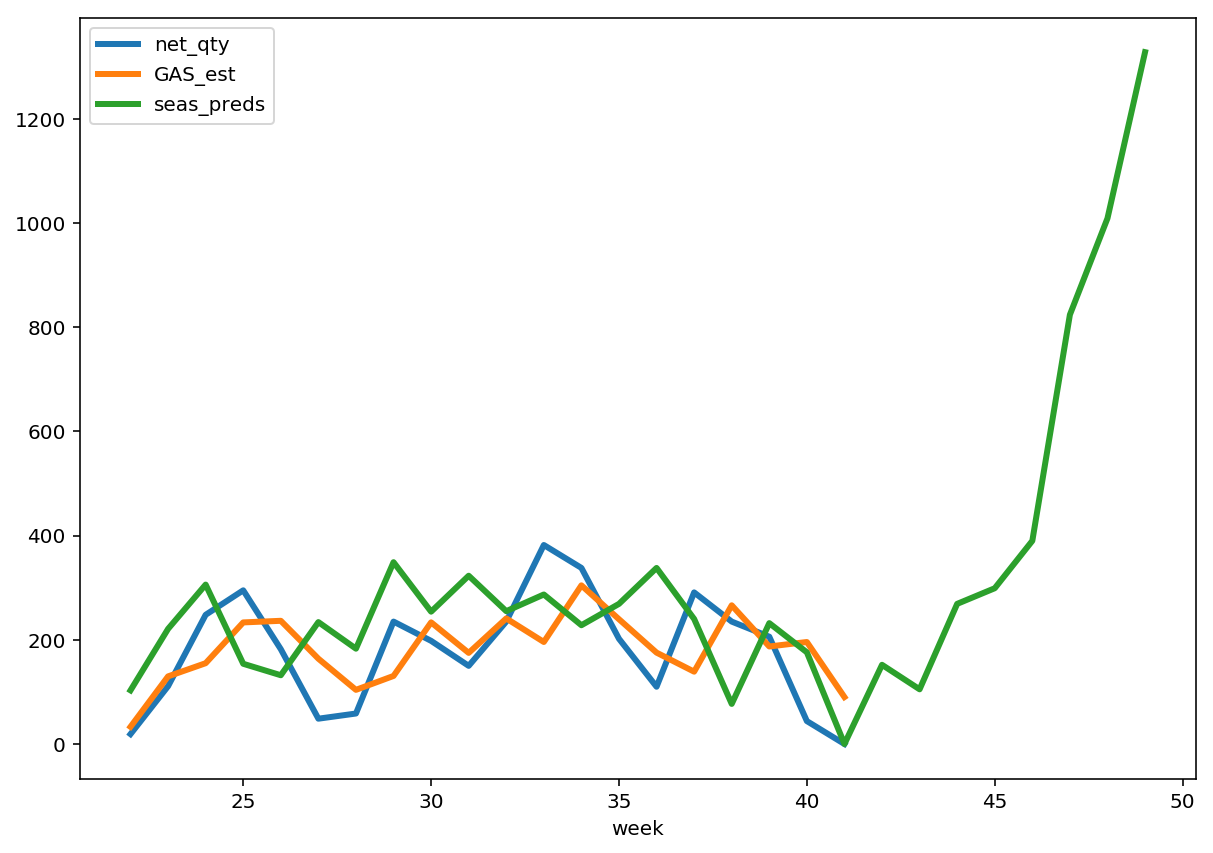

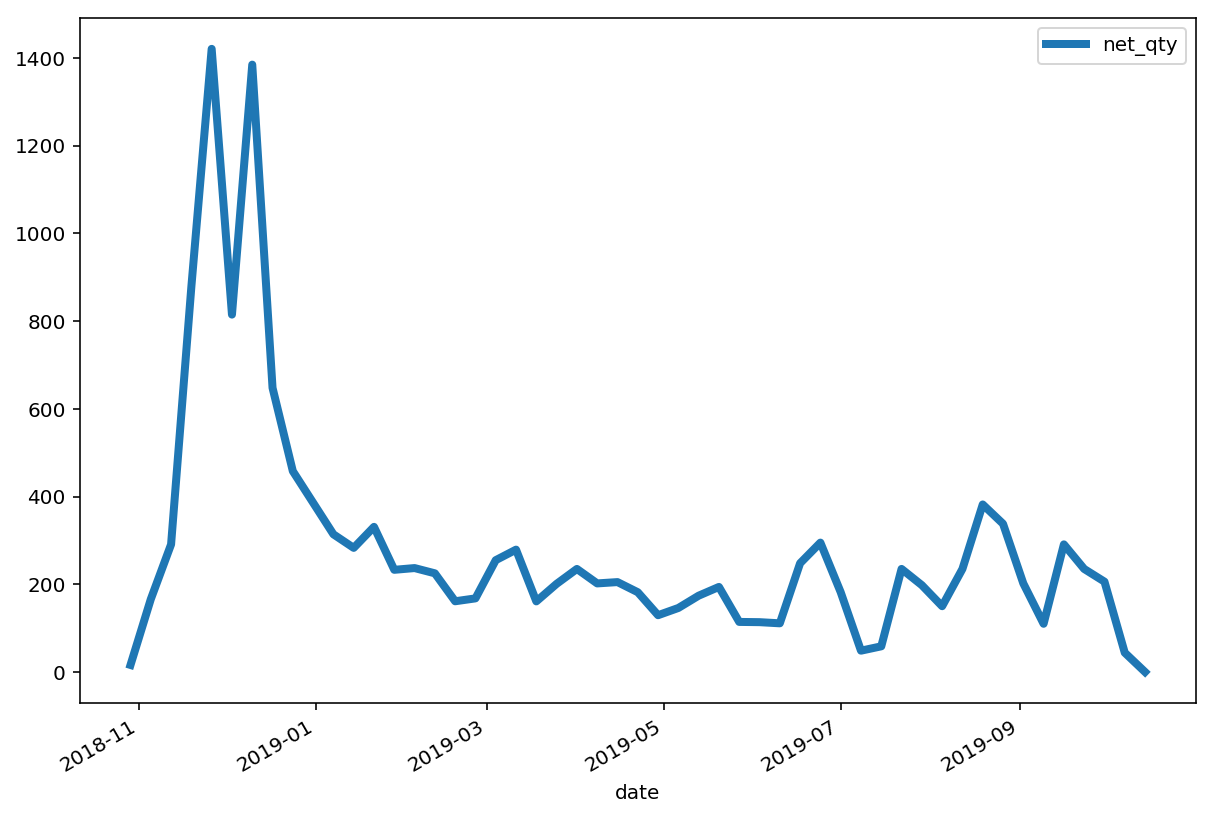

In [59]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
a = 'D95958'
aoi = a

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
      
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season[preds_season.index == a].round()

dat_aoi = us_dat0[us_dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

In [30]:
# preds_season.to_csv("FW20_US_forecasts.csv", sep=',', encoding='utf-8')
preds_season.to_excel("FW20_US_forecasts.xlsx")

In [ ]:
# ---- Plot -----
a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]


dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()
dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum)

preds_season[preds_season.index == a]

dat_aoi = us_dat0[us_dat0.article_number == aoi].copy()
dat_aoi = pd.merge(pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(), dat_aoi[['year', 'week']].drop_duplicates())

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# Old v. New EDA

In [ ]:
old = pd.read_excel('data/old_US_forecasts.xlsx')

In [ ]:
old.head()
preds_season.head()

In [ ]:
comp = pd.merge(
    old[['article_no', 'DAA_forecast']],
    preds_season.reset_index()[['article_no', 'DAA_forecast']],
    left_on = 'article_no', right_on = 'article_no'
)
comp['diff'] = comp.DAA_forecast_x - comp.DAA_forecast_y

comp = comp.rename(columns = {'DAA_forecast_x': 'Old', 'DAA_forecast_y': 'New'})

In [ ]:
comp.sort_values('diff', ascending = False)

In [ ]:
comp.to_excel("comparison.xlsx")

# Appendix

In [ ]:
# def opt_overbuy(y):
#     if y < 1000: 
#         return y*1.20
#     elif y < 2000:
#         return y*1.43
#     elif y < 5000:
#         return y*1.28
#     elif y < 10000:
#         return y*1.21
#     else:
#         return y*1.19
    
